In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import FactorAnalysis
import numpy as np
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
import optuna

# Check scikit-learn < 1.6.0

In [2]:
df = pd.read_csv('datasets\cleaned_data_QS.csv', encoding='latin1')
score_columns = [col for col in df.columns if 'SCORE' in col]
print(score_columns,'score_columns')
print(df.columns,'all_columns')

['AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE', 'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE'] score_columns
Index(['Rank', 'Institution Name', 'Country', 'Year', 'CS', 'CF', 'RI', 'Age',
       'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE', 'IF_SCORE',
       'IS_SCORE', 'IRN_SCORE', 'EO_SCORE', 'S_SCORE', 'Overall'],
      dtype='object') all_columns


In [3]:
# select lower missing-value ratio as features(used in model)
features = ['CS', 'CF', 'RI', 'Age', 'STA', 'AR_SCORE', 'ER_SCORE', 'FS_SCORE', 'CPF_SCORE','IF_SCORE','IS_SCORE','Overall']
targets = ['IRN_SCORE', 'EO_SCORE', 'S_SCORE']

# Fill missing values with institution-specific mean
def fill_na_with_institution_mean(df, column):
    return df[column].fillna(df.groupby('Institution Name')[column].transform('mean'))

# If still missing, filling with country-specific mean
def fill_na_with_country_mean(df, column):
    return df[column].fillna(df.groupby('Country')[column].transform('mean'))

# Fill initial columns with country mean
cols_to_exclude = ['Institution Name', 'Country']
for col in features:
    if col not in cols_to_exclude:
        df[col] = fill_na_with_institution_mean(df, col)
        df[col] = fill_na_with_country_mean(df, col)

In [4]:
# Check missing
missing = df[df.columns].isnull().sum().values / df.shape[0]   # Calculate missing values ratio
for i,column in zip(missing, df.columns):
    print(f"{i * 100:.2f}% missing in",column)

0.00% missing in Rank
0.00% missing in Institution Name
0.00% missing in Country
0.00% missing in Year
0.00% missing in CS
0.00% missing in CF
0.00% missing in RI
0.26% missing in Age
0.14% missing in STA
0.02% missing in AR_SCORE
0.02% missing in ER_SCORE
0.02% missing in FS_SCORE
0.02% missing in CPF_SCORE
0.12% missing in IF_SCORE
0.14% missing in IS_SCORE
41.85% missing in IRN_SCORE
41.81% missing in EO_SCORE
56.92% missing in S_SCORE
4.34% missing in Overall


In [5]:
# Combine features and targets for imputation
all_columns = features + targets
# Split data for training and testing
train_data = df[df['Year'] >= 2024].dropna(subset=all_columns)   # ensure training data are have no missing values
test_data = df[df['Year'] < 2024]

In [6]:
def objective(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.8),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.8),
    }
    model = XGBRegressor(**params, random_state=42, n_jobs=-1, verbosity=0)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -score.mean()

In [7]:
best_params_dict = {}

for target in targets:
    X_train = train_data[features]
    y_train = train_data[target]

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

    best_params = study.best_params
    best_params_dict[target] = best_params

    best_model = XGBRegressor(**best_params, random_state=2025, n_jobs=-1, verbosity=0)
    best_model.fit(X_train, y_train)

    print(f"Best parameters for {target}: {best_params}")

    X_test = test_data[features]
    test_data.loc[:, target] = best_model.predict(X_test)

[I 2025-07-02 21:27:17,305] A new study created in memory with name: no-name-c300f06e-75f0-485a-865a-212b8d4c0a46
[I 2025-07-02 21:27:21,015] Trial 0 finished with value: 25.556684744618966 and parameters: {'n_estimators': 403, 'max_depth': 7, 'learning_rate': 0.2540777123528346, 'subsample': 0.5214298077284235, 'colsample_bytree': 0.7485995005086352, 'reg_alpha': 0.5547297299683408, 'reg_lambda': 0.5580811030245902}. Best is trial 0 with value: 25.556684744618966.
[I 2025-07-02 21:27:22,005] Trial 1 finished with value: 24.376571851093356 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.1619556673422618, 'subsample': 0.696649273891469, 'colsample_bytree': 0.6496255220802201, 'reg_alpha': 0.6842522231001822, 'reg_lambda': 0.7730002724694782}. Best is trial 1 with value: 24.376571851093356.
[I 2025-07-02 21:27:23,415] Trial 2 finished with value: 23.297994088428364 and parameters: {'n_estimators': 486, 'max_depth': 6, 'learning_rate': 0.00618919224144566, 'subsam

[I 2025-07-02 21:27:39,084] Trial 23 finished with value: 23.29347237583748 and parameters: {'n_estimators': 620, 'max_depth': 6, 'learning_rate': 0.009659533488637143, 'subsample': 0.5822209786290617, 'colsample_bytree': 0.519042320516858, 'reg_alpha': 0.2407222093675629, 'reg_lambda': 0.6603067425042051}. Best is trial 23 with value: 23.29347237583748.
[I 2025-07-02 21:27:39,967] Trial 24 finished with value: 23.90317305499474 and parameters: {'n_estimators': 621, 'max_depth': 6, 'learning_rate': 0.044302662156599976, 'subsample': 0.5706312377881964, 'colsample_bytree': 0.5317945409761039, 'reg_alpha': 0.25937019469043504, 'reg_lambda': 0.6520673022732296}. Best is trial 23 with value: 23.29347237583748.
[I 2025-07-02 21:27:40,829] Trial 25 finished with value: 23.56380321404556 and parameters: {'n_estimators': 610, 'max_depth': 6, 'learning_rate': 0.02790141598116915, 'subsample': 0.5412354324254299, 'colsample_bytree': 0.5828856392886724, 'reg_alpha': 0.37628065881888517, 'reg_lamb

[I 2025-07-02 21:27:53,702] Trial 46 finished with value: 23.515187448912656 and parameters: {'n_estimators': 495, 'max_depth': 4, 'learning_rate': 0.039189054712838914, 'subsample': 0.6461214138338174, 'colsample_bytree': 0.7298893043229154, 'reg_alpha': 0.24495045089198145, 'reg_lambda': 0.7749336880245599}. Best is trial 23 with value: 23.29347237583748.
[I 2025-07-02 21:27:54,885] Trial 47 finished with value: 23.585695064765627 and parameters: {'n_estimators': 653, 'max_depth': 6, 'learning_rate': 0.016530673698118264, 'subsample': 0.67906814305931, 'colsample_bytree': 0.791476450901189, 'reg_alpha': 0.5343993947681656, 'reg_lambda': 0.6954644961248265}. Best is trial 23 with value: 23.29347237583748.
[I 2025-07-02 21:27:55,595] Trial 48 finished with value: 24.775927988220943 and parameters: {'n_estimators': 627, 'max_depth': 5, 'learning_rate': 0.1322967823271187, 'subsample': 0.5507992369297472, 'colsample_bytree': 0.6840988888677555, 'reg_alpha': 0.002369552638247563, 'reg_lam

[I 2025-07-02 21:28:09,661] Trial 69 finished with value: 23.5749213980411 and parameters: {'n_estimators': 669, 'max_depth': 6, 'learning_rate': 0.023855317147021816, 'subsample': 0.5027035038897325, 'colsample_bytree': 0.560338335874945, 'reg_alpha': 0.22366154372618174, 'reg_lambda': 0.7745087605484228}. Best is trial 66 with value: 23.25892622256268.
[I 2025-07-02 21:28:10,240] Trial 70 finished with value: 23.931530918488942 and parameters: {'n_estimators': 346, 'max_depth': 6, 'learning_rate': 0.06664113291481831, 'subsample': 0.5441880496073632, 'colsample_bytree': 0.6367593460593208, 'reg_alpha': 0.298707896755982, 'reg_lambda': 0.6367736893005762}. Best is trial 66 with value: 23.25892622256268.
[I 2025-07-02 21:28:10,935] Trial 71 finished with value: 23.370331549591047 and parameters: {'n_estimators': 635, 'max_depth': 5, 'learning_rate': 0.005045737137480529, 'subsample': 0.5640587690636966, 'colsample_bytree': 0.5243883747503983, 'reg_alpha': 0.06440957424499504, 'reg_lamb

[I 2025-07-02 21:28:29,223] Trial 92 finished with value: 23.567616883605822 and parameters: {'n_estimators': 634, 'max_depth': 6, 'learning_rate': 0.019358856892288265, 'subsample': 0.5297621033101118, 'colsample_bytree': 0.5004469685115462, 'reg_alpha': 0.3341943254399979, 'reg_lambda': 0.5128701645392334}. Best is trial 81 with value: 23.227302140437768.
[I 2025-07-02 21:28:30,099] Trial 93 finished with value: 23.267851333658815 and parameters: {'n_estimators': 578, 'max_depth': 6, 'learning_rate': 0.005434031673041996, 'subsample': 0.5493781985120342, 'colsample_bytree': 0.5202556390829752, 'reg_alpha': 0.36131191487643344, 'reg_lambda': 0.5740905991955423}. Best is trial 81 with value: 23.227302140437768.
[I 2025-07-02 21:28:30,975] Trial 94 finished with value: 23.45700506956865 and parameters: {'n_estimators': 608, 'max_depth': 6, 'learning_rate': 0.01721515585786544, 'subsample': 0.5493994135114298, 'colsample_bytree': 0.5211993643734348, 'reg_alpha': 0.31453736733119814, 'reg

Best parameters for IRN_SCORE: {'n_estimators': 571, 'max_depth': 6, 'learning_rate': 0.007244939421478834, 'subsample': 0.598016112784845, 'colsample_bytree': 0.500001896205179, 'reg_alpha': 0.3444619002503842, 'reg_lambda': 0.5674933540910795}


[I 2025-07-02 21:28:37,411] Trial 0 finished with value: 15.203148796194574 and parameters: {'n_estimators': 331, 'max_depth': 4, 'learning_rate': 0.13559462507442294, 'subsample': 0.6285205321575563, 'colsample_bytree': 0.6964354814669946, 'reg_alpha': 0.7254731183035674, 'reg_lambda': 0.7850369517079073}. Best is trial 0 with value: 15.203148796194574.
[I 2025-07-02 21:28:37,536] Trial 1 finished with value: 16.40533003295525 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.028082390365418857, 'subsample': 0.5875259071273101, 'colsample_bytree': 0.533111734403901, 'reg_alpha': 0.7128984630369675, 'reg_lambda': 0.5990317360067484}. Best is trial 0 with value: 15.203148796194574.
[I 2025-07-02 21:28:37,938] Trial 2 finished with value: 15.479511118129674 and parameters: {'n_estimators': 289, 'max_depth': 6, 'learning_rate': 0.16586863091579218, 'subsample': 0.6704553921176608, 'colsample_bytree': 0.5357781573865512, 'reg_alpha': 0.5648077486725923, 'reg_lambda':

[I 2025-07-02 21:28:57,071] Trial 23 finished with value: 14.777002862630349 and parameters: {'n_estimators': 576, 'max_depth': 6, 'learning_rate': 0.02931011904900777, 'subsample': 0.7639873034683791, 'colsample_bytree': 0.5821404340173805, 'reg_alpha': 0.22144557968642378, 'reg_lambda': 0.5456720233550406}. Best is trial 3 with value: 14.527482759420211.
[I 2025-07-02 21:28:58,466] Trial 24 finished with value: 14.51921766340096 and parameters: {'n_estimators': 614, 'max_depth': 7, 'learning_rate': 0.02975314576493576, 'subsample': 0.7099732916845156, 'colsample_bytree': 0.6232933139271262, 'reg_alpha': 0.33152095683561544, 'reg_lambda': 0.3992209715517606}. Best is trial 24 with value: 14.51921766340096.
[I 2025-07-02 21:28:59,451] Trial 25 finished with value: 14.736162161232963 and parameters: {'n_estimators': 659, 'max_depth': 6, 'learning_rate': 0.058201634190215026, 'subsample': 0.6949067080045299, 'colsample_bytree': 0.6155056875522137, 'reg_alpha': 0.3332660948425187, 'reg_la

[I 2025-07-02 21:29:22,937] Trial 46 finished with value: 14.568693238557385 and parameters: {'n_estimators': 523, 'max_depth': 6, 'learning_rate': 0.09759239572696476, 'subsample': 0.7578494897720349, 'colsample_bytree': 0.7931558255826195, 'reg_alpha': 0.02591183550925002, 'reg_lambda': 0.7685169463914453}. Best is trial 41 with value: 14.29946845676939.
[I 2025-07-02 21:29:23,570] Trial 47 finished with value: 14.596121961123485 and parameters: {'n_estimators': 371, 'max_depth': 6, 'learning_rate': 0.0533914827738665, 'subsample': 0.7798549366736095, 'colsample_bytree': 0.7784445125927792, 'reg_alpha': 0.04313974054861638, 'reg_lambda': 0.6199514358455852}. Best is trial 41 with value: 14.29946845676939.
[I 2025-07-02 21:29:24,605] Trial 48 finished with value: 14.578788958751057 and parameters: {'n_estimators': 447, 'max_depth': 7, 'learning_rate': 0.07653276102873904, 'subsample': 0.7960178207426721, 'colsample_bytree': 0.7451607503026765, 'reg_alpha': 0.12734932288449186, 'reg_la

[I 2025-07-02 21:29:54,003] Trial 69 finished with value: 15.118191177211628 and parameters: {'n_estimators': 626, 'max_depth': 7, 'learning_rate': 0.22284164350357955, 'subsample': 0.7157548958602495, 'colsample_bytree': 0.7991031108122955, 'reg_alpha': 0.2241218710157869, 'reg_lambda': 0.5733524282570603}. Best is trial 41 with value: 14.29946845676939.
[I 2025-07-02 21:29:55,590] Trial 70 finished with value: 14.54547834047836 and parameters: {'n_estimators': 663, 'max_depth': 7, 'learning_rate': 0.06901165164943746, 'subsample': 0.7039706404166096, 'colsample_bytree': 0.7186259567314311, 'reg_alpha': 0.06425258207996765, 'reg_lambda': 0.6805722329288422}. Best is trial 41 with value: 14.29946845676939.
[I 2025-07-02 21:29:57,149] Trial 71 finished with value: 14.401956025654885 and parameters: {'n_estimators': 625, 'max_depth': 7, 'learning_rate': 0.05129842931087074, 'subsample': 0.7490971947841305, 'colsample_bytree': 0.7991963272231235, 'reg_alpha': 0.10933975273131365, 'reg_lam

[I 2025-07-02 21:30:25,652] Trial 92 finished with value: 14.360042312568732 and parameters: {'n_estimators': 605, 'max_depth': 7, 'learning_rate': 0.04196743925312439, 'subsample': 0.7928299055472813, 'colsample_bytree': 0.7613725428550838, 'reg_alpha': 0.16907882810928251, 'reg_lambda': 0.44234359182505417}. Best is trial 41 with value: 14.29946845676939.
[I 2025-07-02 21:30:27,029] Trial 93 finished with value: 14.68799830875144 and parameters: {'n_estimators': 557, 'max_depth': 7, 'learning_rate': 0.012245344081851715, 'subsample': 0.7894081871653602, 'colsample_bytree': 0.7583613158190577, 'reg_alpha': 0.4162208730100596, 'reg_lambda': 0.7757219688111594}. Best is trial 41 with value: 14.29946845676939.
[I 2025-07-02 21:30:28,391] Trial 94 finished with value: 14.516523990605606 and parameters: {'n_estimators': 602, 'max_depth': 7, 'learning_rate': 0.04033919392004441, 'subsample': 0.7901900168715164, 'colsample_bytree': 0.7498183457545231, 'reg_alpha': 0.16511568534246707, 'reg_l

Best parameters for EO_SCORE: {'n_estimators': 605, 'max_depth': 7, 'learning_rate': 0.04645932962004284, 'subsample': 0.7004294587371978, 'colsample_bytree': 0.7539090599490689, 'reg_alpha': 0.17822969582734985, 'reg_lambda': 0.7779300895286217}


[I 2025-07-02 21:30:35,254] Trial 0 finished with value: 18.508634697120154 and parameters: {'n_estimators': 168, 'max_depth': 6, 'learning_rate': 0.06047316018139411, 'subsample': 0.7852737582169046, 'colsample_bytree': 0.5218044462041836, 'reg_alpha': 0.353650941115381, 'reg_lambda': 0.3114929411690759}. Best is trial 0 with value: 18.508634697120154.
[I 2025-07-02 21:30:35,565] Trial 1 finished with value: 19.218363472776566 and parameters: {'n_estimators': 543, 'max_depth': 3, 'learning_rate': 0.14758511435221508, 'subsample': 0.6362431628092893, 'colsample_bytree': 0.5759551132910108, 'reg_alpha': 0.7955958610579528, 'reg_lambda': 0.6145937486874952}. Best is trial 0 with value: 18.508634697120154.
[I 2025-07-02 21:30:35,791] Trial 2 finished with value: 18.87415980642091 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.11839789986529942, 'subsample': 0.7696662287130847, 'colsample_bytree': 0.6355118595329718, 'reg_alpha': 0.5385684958489151, 'reg_lambda': 

[I 2025-07-02 21:30:54,816] Trial 23 finished with value: 18.127940449067808 and parameters: {'n_estimators': 627, 'max_depth': 7, 'learning_rate': 0.030354333233517695, 'subsample': 0.7245989251334972, 'colsample_bytree': 0.660249747078164, 'reg_alpha': 0.3908051172023006, 'reg_lambda': 0.34881173053700126}. Best is trial 22 with value: 18.028189858913493.
[I 2025-07-02 21:30:55,813] Trial 24 finished with value: 18.092049578105858 and parameters: {'n_estimators': 406, 'max_depth': 7, 'learning_rate': 0.028663953457101467, 'subsample': 0.7561261375716207, 'colsample_bytree': 0.7243670433089678, 'reg_alpha': 0.504944477811505, 'reg_lambda': 0.5936666650993438}. Best is trial 22 with value: 18.028189858913493.
[I 2025-07-02 21:30:56,809] Trial 25 finished with value: 18.05727191542421 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.08893836853666931, 'subsample': 0.7441814005678847, 'colsample_bytree': 0.725714141550268, 'reg_alpha': 0.6159409487291309, 'reg_lam

[I 2025-07-02 21:31:13,787] Trial 46 finished with value: 17.96145641029538 and parameters: {'n_estimators': 373, 'max_depth': 7, 'learning_rate': 0.05513217417557589, 'subsample': 0.6106601571750703, 'colsample_bytree': 0.7631455781795168, 'reg_alpha': 0.7957387815649111, 'reg_lambda': 0.5304020267674363}. Best is trial 38 with value: 17.944762561115706.
[I 2025-07-02 21:31:15,277] Trial 47 finished with value: 18.11534505313807 and parameters: {'n_estimators': 561, 'max_depth': 7, 'learning_rate': 0.10047095043852403, 'subsample': 0.6097848668387386, 'colsample_bytree': 0.7590884937947072, 'reg_alpha': 0.6992362447756021, 'reg_lambda': 0.5780209688179991}. Best is trial 38 with value: 17.944762561115706.
[I 2025-07-02 21:31:16,372] Trial 48 finished with value: 18.008294609438337 and parameters: {'n_estimators': 438, 'max_depth': 7, 'learning_rate': 0.05692995265496568, 'subsample': 0.5683262490925216, 'colsample_bytree': 0.7401797976831926, 'reg_alpha': 0.7838336767861959, 'reg_lamb

[I 2025-07-02 21:31:37,547] Trial 69 finished with value: 18.066061460174836 and parameters: {'n_estimators': 421, 'max_depth': 7, 'learning_rate': 0.03496320038026486, 'subsample': 0.6207443169302198, 'colsample_bytree': 0.7275322214791639, 'reg_alpha': 0.5291126927152051, 'reg_lambda': 0.7730790637509624}. Best is trial 64 with value: 17.901151460529686.
[I 2025-07-02 21:31:38,502] Trial 70 finished with value: 18.12310287540716 and parameters: {'n_estimators': 390, 'max_depth': 7, 'learning_rate': 0.06587598629534444, 'subsample': 0.5993798497244756, 'colsample_bytree': 0.5947586583557904, 'reg_alpha': 0.6053696028067277, 'reg_lambda': 0.72672689990858}. Best is trial 64 with value: 17.901151460529686.
[I 2025-07-02 21:31:39,480] Trial 71 finished with value: 17.931951202934034 and parameters: {'n_estimators': 348, 'max_depth': 7, 'learning_rate': 0.07404223751231284, 'subsample': 0.6389536569437619, 'colsample_bytree': 0.7728266971688288, 'reg_alpha': 0.6525137532655992, 'reg_lambd

[I 2025-07-02 21:32:00,936] Trial 92 finished with value: 18.603716177329705 and parameters: {'n_estimators': 397, 'max_depth': 7, 'learning_rate': 0.24412016574480178, 'subsample': 0.6757454611029472, 'colsample_bytree': 0.7736559137001893, 'reg_alpha': 0.6324244022836069, 'reg_lambda': 0.6659052999433759}. Best is trial 64 with value: 17.901151460529686.
[I 2025-07-02 21:32:01,913] Trial 93 finished with value: 17.980548831901615 and parameters: {'n_estimators': 358, 'max_depth': 7, 'learning_rate': 0.03493435918283767, 'subsample': 0.6651727324072817, 'colsample_bytree': 0.7747088506783374, 'reg_alpha': 0.6213478137253822, 'reg_lambda': 0.6285748370114358}. Best is trial 64 with value: 17.901151460529686.
[I 2025-07-02 21:32:02,893] Trial 94 finished with value: 17.955815526076734 and parameters: {'n_estimators': 364, 'max_depth': 7, 'learning_rate': 0.04712265967541131, 'subsample': 0.7813002307014353, 'colsample_bytree': 0.7985363960257952, 'reg_alpha': 0.7006480998960631, 'reg_la

Best parameters for S_SCORE: {'n_estimators': 371, 'max_depth': 7, 'learning_rate': 0.051387036952804555, 'subsample': 0.7782776810720853, 'colsample_bytree': 0.7978818311455503, 'reg_alpha': 0.7045629222310879, 'reg_lambda': 0.6144716068821324}


In [8]:
combined_data = pd.concat([test_data, train_data])
combined_data = combined_data.dropna(subset=all_columns) 
combined_data.to_csv('datasets\imputed_data_QS_XGB.csv', index=False)

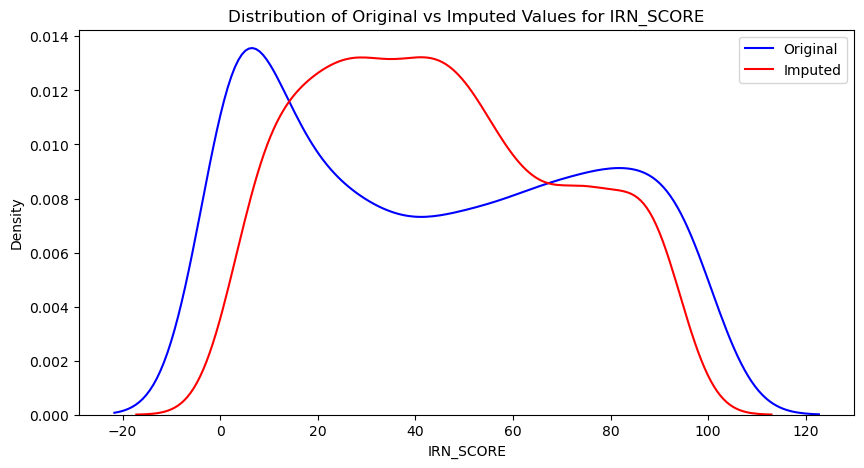

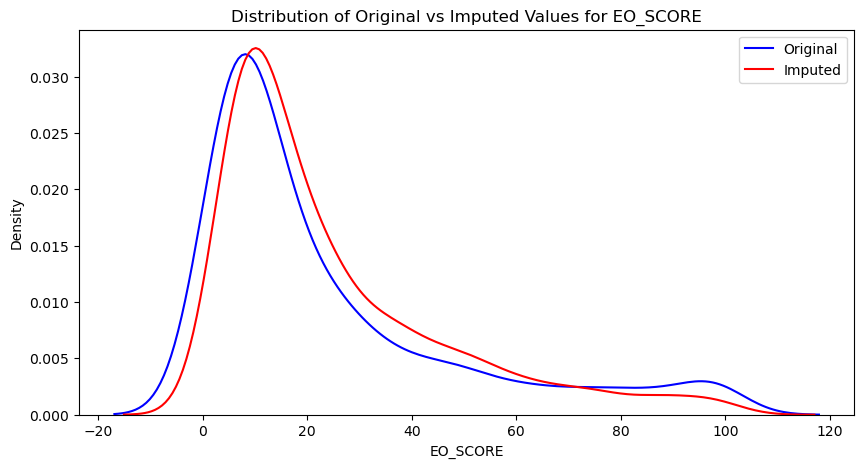

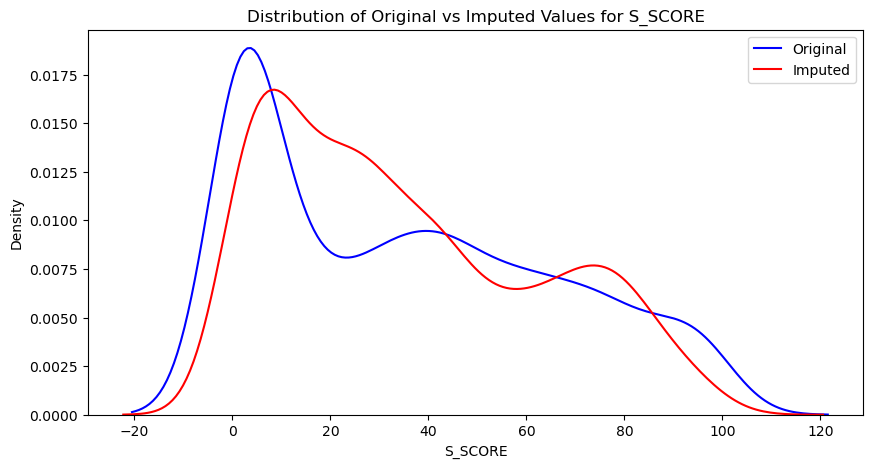

      target       R^2       RMSE        MAE
0  IRN_SCORE  0.672404  18.529145  14.424001
1   EO_SCORE  0.669824  14.664380   9.789186
2    S_SCORE  0.742957  15.550190  11.855022


In [11]:
synthetic_data = train_data.copy().dropna()
for target in targets:
    mask = synthetic_data[target].notna()
    n_to_remove = int(0.35 * mask.sum())
    indices_to_nan = np.random.choice(synthetic_data[mask].index, n_to_remove, replace=False)
    synthetic_data.loc[indices_to_nan, target] = np.nan

# 评估部分
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

for target in targets:
    train_synthetic = synthetic_data[synthetic_data[target].notna()]
    test_synthetic = synthetic_data[synthetic_data[target].isna()]

    X_train = train_synthetic[features]
    y_train = train_synthetic[target]
    X_test = test_synthetic[features]
    y_true = train_data.loc[test_synthetic.index, target]

    best_params = best_params_dict[target]
    model = XGBRegressor(**best_params, random_state=42, n_jobs=-1, verbosity=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    metrics['target'].append(target)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)

    # Plot distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {target}")
    plt.xlabel(target)
    plt.legend()
    plt.show()
    
metrics_df = pd.DataFrame(metrics)
print(metrics_df)